# Simulated Aberration Recovery  
## Dataset Generation
Gautam Gunjala  
UC Berkeley Computational Imaging Lab  
05/2018

Simulates a dataset of images taken by an imaging system with field-invariant aberrations under different angles of plane-wave illumination. For the case of field-varying aberrations, this exact procedure is applied to sub-regions of the full-field image.

In [1]:
import numpy                 as np
import numpy.fft             as nf
import scipy                 as sp
import matplotlib.pyplot     as plt
import matplotlib.image      as mpimg
import imgUtil               as iu
import mathUtil              as mu
import calibrationUtil       as cu
import plotUtil              as pu

from scipy                   import special
from scipy                   import optimize
from scipy                   import io

## Imaging system parameters  
Assign values to constants based on the imaging system you would like to simulate.  
`lam` is the illumination wavelength.  
`nx,ny` are the number of pixels in the $x$- and $y$- axes, respectively.  
`ps` is the pixel size along one dimension (assumed square).

In [2]:
############################################################
#####  EDIT THESE VALUES BASED ON YOUR IMAGING SYSTEM  #####
############################################################
 
lam     = 632e-9
nx,ny   = (256,256)
ps      = 5.3e-6

In [3]:
x       = np.arange(-(nx//2), (nx//2), 1) *ps
y       = np.arange(-(ny//2), (ny//2), 1) *ps
X,Y     = np.meshgrid(x,y)

dfx,dfy = (1/(nx*ps), 1/(ny*ps))
fx      = np.arange(-(nx//2), (nx//2), 1) *dfx
fy      = np.arange(-(ny//2), (ny//2), 1) *dfy
Fx,Fy   = np.meshgrid(fx,fy)

NA      = 0.025
fc      = NA/lam
Pupil   = 1*((Fx**2 + Fy**2) < (fc**2))

zloc    = (Pupil == 0)
nanPup  = np.ones((nx,ny))
nanPup[zloc] = np.nan

nfx,nfy = (fx/fc,fy/fc)
nFx,nFy = np.meshgrid(nfx,nfy)

## Create diffuser object  
Assign values to constants based on the diffuser being imaged.  
`sigma` adjusts the autocorrelation width of the diffuser's phase. Large values result in poor visibility of spatial frequencies, and hence poor performance. Ideally, this value is no more than ~3 times the pixel size.  
`scale` adjusts the range of values that the diffuser's phase can span (not a direct relationship due to convolution - see colorbar in plot below). Large values result in mismatch with the linearized model, and hence poor performance. Ideally, this range is no larger than $\left[ -\frac{\pi}{4}, \frac{\pi}{4} \right]$.

The model for the diffuser is $E_{0}(x) = \exp \{ i \cdot \varphi(x) \} $, where the phase, $\varphi(x)$ is given by the convolution of white noise and a Gaussian kernel. 

In [4]:
############################################################
#####       EDIT THESE VALUES BASED ON SCATTERER       #####
############################################################

sigma   = 1*ps          # Adjusts stationarity of phase
scale   = 5e-12         # Adjusts accuracy of linearization

Text(0,0.5,'y')

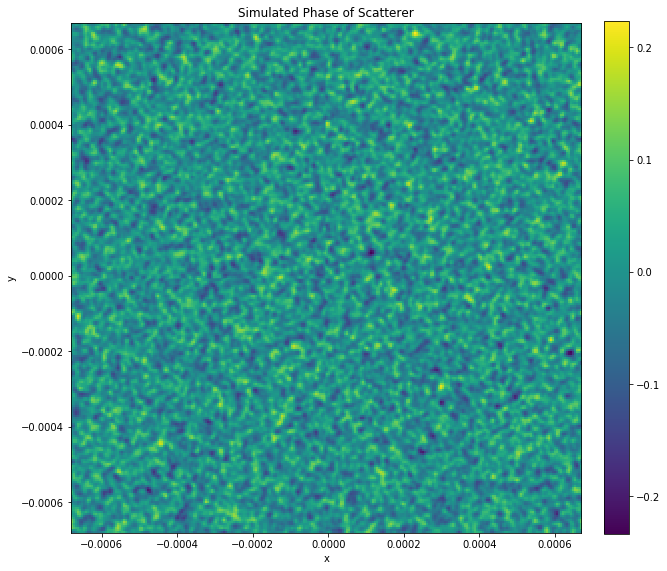

In [5]:
a       = 0.5/(sigma**2)
gwin_r  = scale*(0.5/(np.pi*sigma**2))*np.exp(-a*(X**2 + Y**2))
gwin    = scale*np.exp(-2*(np.pi**2)*(sigma**2)*(Fx**2 + Fy**2))

temp    = np.random.randn(nx,ny)
phix    = np.real(iu.ifft2c(iu.fft2c(temp)*iu.fft2c(gwin_r)))

E0x     = np.exp(1j*phix)
E0u     = iu.fft2c(E0x)

plt.figure(figsize=(10,10))
pu.imagesc(phix,x,y,axis="xy",cbar=1)
plt.title("Simulated Phase of Scatterer")
plt.xlabel("x")
plt.ylabel("y")

## Diffuser characterization

An image is taken significantly out of focus to ensure that features of the intensity spatial frequency spectrum are primarily a result of the defocus aberration coefficient. By fitting this coefficient, we can determine a Gaussian window function and the Rayleigh distribution parameter of the residual noise values.

In [6]:
z       = 1e-3
(E1x,H) = iu.propagate(E0x,lam,z,ps)
Ix      = np.abs(E1x)**2
P       = (iu.rmvDC(np.abs(iu.fft2c(Ix)))[0])**2

fx2fy2  = nFx**2 + nFy**2
c       = ( (nx**2)*ps*np.sqrt(2*np.pi), -2*(np.pi*fc*ps)**2, np.pi*lam*(1e-6)*(fc**2) )
fxp     = fx[nx//2:]/fc

In [7]:
func    = lambda x: cu.diffCharSSE(x,c,fx2fy2,P)
x0      = np.array([100,1000,1])

out     = sp.optimize.fmin(func,x0)
iavg    = np.sqrt(iu.radialAvg(P))

Optimization terminated successfully.
         Current function value: 46722410112.658279
         Iterations: 106
         Function evaluations: 200


In [8]:
xf      = fxp*fc*(1e-6)
tmp     = c[0]*(out[0]/out[2])*np.exp(c[1]*(out[2]**2)*fx2fy2)
d1      = np.abs(tmp[nx//2,nx//2:])*np.abs(np.sin(c[2]*out[1]*(fxp**2)))
d2      = np.abs(tmp[nx//2,nx//2:])

gwin    = tmp*(ps**2)/(2*nx)
sigma   = out[2]*ps
scale   = gwin[nx//2,nx//2]

phiEst  = gwin*nx/(ps**2)

In [9]:
Pe      = np.abs(gwin*nx/(ps**2))**2 *(2*np.sin(c[2]*out[1]*(fx2fy2)))**2
r       = np.sqrt(iu.rmvDC(P)[0])/np.sqrt(Pe)
use     = ((Pe/np.max(Pe) > 0.1) & (fx2fy2 <= 1))
rr      = r[use]
K       = rr.shape[0]
sigmaR  = np.sqrt(np.sum(rr**2/(2*K)))*np.exp(1)*np.sqrt(K/(K-1))*((K-1)/K)**K
raylMu  = sigmaR*np.sqrt(np.pi/2)

C:\Users\gauta\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


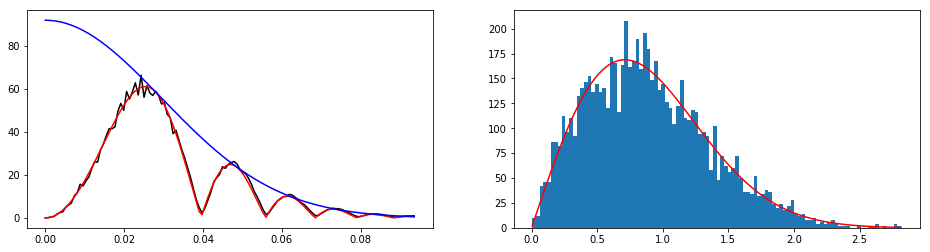

In [10]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(xf,iavg,'k',xf,d1,'r',xf,d2,'b')

plt.subplot(122)
n,xh,q  = plt.hist(rr,100)
rayl    = xh/(sigmaR**2)*(np.exp(-1*(xh**2)/(2*(sigmaR**2))))
plt.plot(xh,rayl*K/np.sum(rayl),'r')

*Left*: Radial average of intensity spectrum shown in black, radial cutline of Gaussian window function shown in blue, fitted intensity spectrum due to defocus only shown in red.

*Right*: Histogram of residual noise values (which describe surface randomness) with fitted Rayleigh distribution shown in red.

## Simulate Measurement Acquisition

Create a Wavefront Error Function (WEF) with random Zernike coefficients of up to polynomial degree 5, and use WEF to create pupil function as a filter applied to the scattering object. Different illumination angles will change the structure of the output spatial frequency spectrum. 

Text(0.5,1,'Wavefront Error Function of simulated optical system')

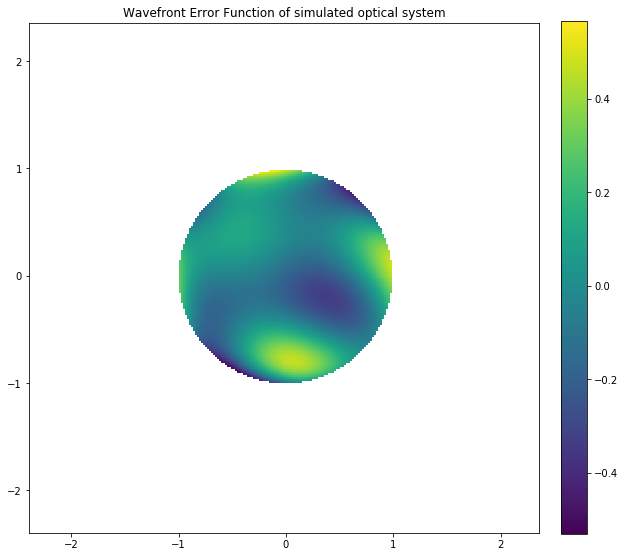

In [11]:
maxD    = 5
B       = mu.zernikeBasis(maxD,nFx,nFy)
Z       = mu.zernikeStandardBasisConversion(maxD)

zcoefT  = 0.05*np.random.randn(21,1)
zcoefT[0:3] = 0
scoefT  = np.linalg.lstsq(Z,zcoefT,rcond=None)[0]
WEF     = mu.polyEval2D(zcoefT,B)

plt.figure(figsize=(10,10))
pu.imagesc(WEF*nanPup,nfx,nfy,axis="xy",cbar=1)
plt.title("Wavefront Error Function of simulated optical system")

In [12]:
######################################################################
#####       EDIT THESE VALUES BASED ON ILLUMINATION ANGLES       #####
######################################################################

srcs    = np.array([ [0,0], \
                     [0,0.3], \
                     [45,0.3], \
                     [90,0.3] ])

In [13]:
numImg  = srcs.shape[0]
U       = np.zeros(numImg)
V       = np.zeros(numImg)

meas    = ()
pupDom  = ()
for i in np.arange(numImg):
    src     = srcs[i]
    d       = lam/mu.sind(src[1])
    ffx     = mu.cosd(src[0])/d
    ffy     = mu.sind(src[0])/d
    U[i]    = ffx/fc
    V[i]    = ffy/fc
    
    sPup    = 1*( (nFx+U[i])**2 + (nFy+V[i])**2 <= 1 )
    sscoef  = mu.poly2DTransformCoeffs(scoefT,maxD,U[i],V[i])
    sWEF    = mu.polyEval2D(np.dot(Z,sscoef),B)
    meas    = meas + (np.abs( iu.ifft2c(E0u *sPup *np.exp(1j*sWEF)) )**2,)
    
    mm1     = ( (nFx + U[i])**2 + (nFy + V[i])**2 ) <= 1
    mm2     = ( (-nFx + U[i])**2 + (-nFy + V[i])**2 ) <= 1
    pupDom  = pupDom + (1*(mm1 & mm2),)

C:\Users\gauta\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: divide by zero encountered in double_scalars


## Plot Simulated Measurement Spectra

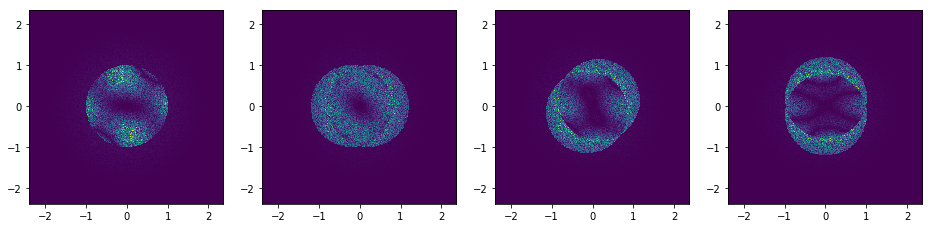

In [14]:
plt.figure(figsize=(16,64))
for i in np.arange(numImg):
    plt.subplot(141+i)
    pu.imagesc(iu.rmvDC(np.abs(iu.fft2c(meas[i])))[0],nfx,nfy,axis="xy")

## Save dataset  
`meas`    - tuple containing simulated measurements  
`pupDom`  - tuple containing interference domains  
`pupTrue` - true pupil function cropped to pupil  
`Pupil`   - on-axis pupil (circ bandlimited by NA)  
`nFx`     - normalized frequency $x$-coordinates  
`nFy`     - normalized frequency $y$-coordinates  
`fc`      - cutoff frequency (unnormalized)  
`NA`      - system NA  
`ps`      - system pixel size  
`lam`     - illumination wavelength  
`U`       - illumination angles in $u$  
`V`       - illumination angles in $v$  
`coef`    - true standard basis coefficients of WEF  
`raylMu`  - mean of estimated Rayleigh distribution  

In [15]:
name    = "test_rand_0.25"
sp.io.savemat( name, dict([("meas", meas), \
                           ("pupDom", pupDom), \
                           ("pupTrue", WEF*Pupil), \
                           ("Pupil", Pupil), \
                           ("phiEst", phiEst), \
                           ("nFx", nFx), \
                           ("nFy", nFy), \
                           ("fc", fc), \
                           ("NA", NA), \
                           ("ps", ps), \
                           ("lam", lam), \
                           ("U", U), \
                           ("V", V), \
                           ("coef", scoefT), \
                           ("raylMu", raylMu)]) ) 